<a href="https://colab.research.google.com/github/upadhyan/Twitter-Stock-Prediction-Deep-Learning-L2RW/blob/main/NLP_L2RW_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/NLP\ Stock\ Prediction/New\ Work
!pip install pytorch-ignite
!pip install higher
## NN imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext.legacy import data, datasets
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import higher
from ignite.metrics import Precision, Recall
import gc

## Others

import itertools
import random
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

#Configs
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

/content/drive/My Drive/Colab Notebooks/NLP Stock Prediction/New Work
     |████████████████████████████████| 204kB 8.5MB/s 


# Baseline
## Class and Function Definitions

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text): 
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        embedded = embedded.swapdims(0,2)
        #print(f"embedded unsqueezed: {embedded.shape}")
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]          
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))   
        #print(f"cat shape: {cat.shape}")       
        return self.fc(cat)

def prep_model(train_file, test_file, device, num_epochs = 100, drpout = 0.25):
  params = {
    'max_vocab': 20000,
    'epochs':num_epochs,
    'batch_size':64,
    'dropout':drpout,
    'lr':.0001
  }
  SEED = 1234
  TEXT= data.Field()
  LABEL = data.LabelField(dtype=torch.float)

  fields = {'text': ('t', TEXT), 'label': ('l', LABEL)}

  train_set, test_data = data.TabularDataset.splits(
      path='model_data',
      train = train_file,
      test = test_file,
      format = 'json',
      fields = fields
  )
  train_data, valid_data = train_set.split(random_state = random.seed(SEED))
  TEXT.build_vocab(train_data, max_size = params['max_vocab'], vectors =  'glove.twitter.27B.100d');
  LABEL.build_vocab(train_data);
  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, valid_data, test_data), 
      batch_size = params['batch_size'],
      sort_within_batch = True,
      sort_key = lambda x: len(x.t),
      device = device)
  INPUT_DIM = len(TEXT.vocab)
  EMBEDDING_DIM = 100
  N_FILTERS = 110
  FILTER_SIZES = [1,2,3,4,5]
  OUTPUT_DIM = 1
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, params['dropout'], PAD_IDX)
  
  pretrained_embeddings = TEXT.vocab.vectors
  ################################################
  if TEXT.vocab.vectors != None:
    model.embedding.weight.data.copy_(pretrained_embeddings);
  ####################################################
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

  optimizer = optim.SGD(model.parameters(), lr=params['lr'])
  criterion = nn.BCEWithLogitsLoss()
  model = model.to(device)
  criterion = criterion.to(device)
  return model, optimizer, criterion, train_iterator, valid_iterator, test_iterator
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc
def train(model, iterator, optimizer, criterion):
    criterion.reduction = 'mean'
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()

        predictions = model(batch.t)

        predictions = predictions.squeeze(1)
        loss = criterion(predictions, batch.l)
        
        acc = binary_accuracy(predictions, batch.l)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_test(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  true_positives = 0
  false_positives = 0
  false_negatives = 0
  true_negatives = 0
  criterion.reduction = 'mean'
  with torch.no_grad():
    model.eval()
    for batch in iterator:
        predictions = model(batch.t)
        loss = criterion(predictions.squeeze(), batch.l)    
        acc = binary_accuracy(predictions.squeeze(), batch.l)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        np_predictions = rounded_preds.squeeze().clone().cpu().numpy()
        np_truth = batch.l.clone().cpu().numpy()        
        true_positives += np.sum(np.logical_and(np_predictions == 1, np_truth == 1))
        false_positives += np.sum(np.logical_and(np_predictions == 1, np_truth == 0))
        false_negatives += np.sum(np.logical_and(np_predictions == 0, np_truth == 1))
        true_negatives += np.sum(np.logical_and(np_predictions == 0, np_truth == 0))
        epoch_loss += loss.item()
        epoch_acc += acc.item()
  precision = true_positives / (true_positives + false_positives)
  recall = true_positives / (true_positives + false_negatives)
  #b = epoch_rec.compute()
  return epoch_loss / len(iterator), epoch_acc / len(iterator), precision, recall

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.t).squeeze(1)
            
            loss = criterion(predictions, batch.l)
            
            acc = binary_accuracy(predictions, batch.l)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def run_experiment(train_file, test_file, device, num_epochs = 100, drpout = 0.25):
  print(f"Running Experiment with {num_epochs} epochs and {drpout} dropout--------------------")
  print("Using ", train_file, " and ", test_file, "For this Experiment")
  params = {
    'max_vocab': 20000,
    'epochs':num_epochs,
    'batch_size':64,
    'dropout':drpout,
    'lr':.0001
  }
  testing_stats = {
    "label":f"{num_epochs}_{drpout}_{test_file}_{train_file}_experiment",
    "precision":0,
    "recall":0,
    "accuracy":0,
    "loss":0
  }
  accuracy_stats = {
    'train': np.zeros(params['epochs']),
    "val": np.zeros(params['epochs'])
  }
  loss_stats = {
    'train': np.zeros(params['epochs']),
    "val": np.zeros(params['epochs'])
  }
  for i in tqdm(range(4)):
    model, optimizer, criterion, train_iterator, valid_iterator, test_iterator = prep_model(train_file, test_file, device, num_epochs=num_epochs, drpout = drpout)
    best_valid_loss = float('inf')
    for epoch in range(params['epochs']):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        accuracy_stats['train'][epoch] += train_acc
        accuracy_stats['val'][epoch] += valid_acc
        loss_stats['train'][epoch] += train_loss
        loss_stats['val'][epoch] += valid_loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut4-model.pt')
    model.load_state_dict(torch.load('tut4-model.pt'))
    test_loss, test_acc,precision,recall = evaluate_test(model, test_iterator, criterion)
    testing_stats['accuracy'] += test_acc
    testing_stats['loss'] += test_loss
    testing_stats['precision'] += precision
    testing_stats['recall'] += recall
  testing_stats['precision'] /=4
  testing_stats['recall'] /=4
  testing_stats['accuracy'] /=4
  testing_stats['loss'] /=4
  print(f"Average Test Loss: {testing_stats['loss']:.3f} | Average Test Accuracy: {testing_stats['accuracy']:.3f}")
  print(f"Average Test Precision: {testing_stats['precision']:.3f} | Average Test Recall:  {testing_stats['recall']:.3f}")
  accuracy_stats['train'] /=4
  accuracy_stats['val'] /=4
  loss_stats['train'] /=4
  loss_stats['val'] /=4
  fig, axs = plt.subplots(2, figsize=(10,10))
  axs[0].set_title('Validation and Training Accuracy', fontsize=20)
  axs[0].plot(range(1,params['epochs'] + 1), accuracy_stats['train'], label='train acc');
  axs[0].plot(range(1,params['epochs'] + 1), accuracy_stats['val'], label='validation acc');
  axs[0].set_xlabel('Epochs', fontsize=16)
  axs[0].set_ylabel('Accuracy', fontsize=16)
  axs[0].legend(prop={"size":16})
  axs[1].set_title('Validation and Training Loss', fontsize=20)
  axs[1].plot(range(1, params['epochs'] + 1), loss_stats['train'], label='train loss')
  axs[1].plot(range(1, params['epochs'] + 1), loss_stats['val'], label='validation loss')
  axs[1].set_xlabel('Epochs', fontsize=16)
  axs[1].set_ylabel('Loss', fontsize=16)
  axs[1].legend(prop={"size":16})
  plt.tight_layout()
  plot_name = "experimental_figures/"+testing_stats['label'] + ".jpg"
  fig.savefig(plot_name)
  return testing_stats

## Epoch BaseLine Experiments

## Messy Set

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_messy_train_set_100.json  and  combined_messy_test_set_100.json For this Experiment



Average Test Loss: 0.692 | Average Test Accuracy: 0.516
Average Test Precision: 0.500 | Average Test Recall:  0.352


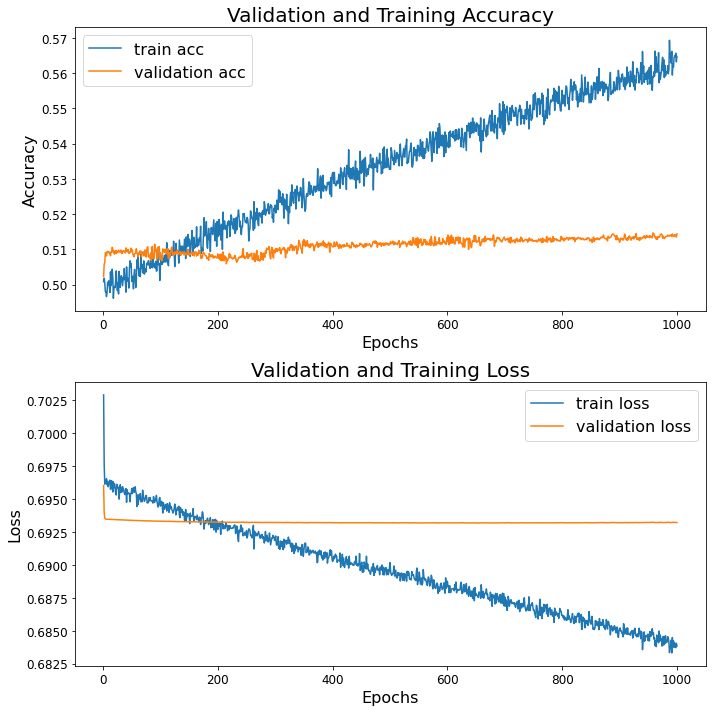

In [ ]:
device = torch.device('cuda')
train_file = 'combined_messy_train_set_100.json'
test_file  = 'combined_messy_test_set_100.json'
messy_base = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_messy_train_set_50.json  and  combined_messy_test_set_50.json For this Experiment



Average Test Loss: 0.693 | Average Test Accuracy: 0.510
Average Test Precision: 0.492 | Average Test Recall:  0.474


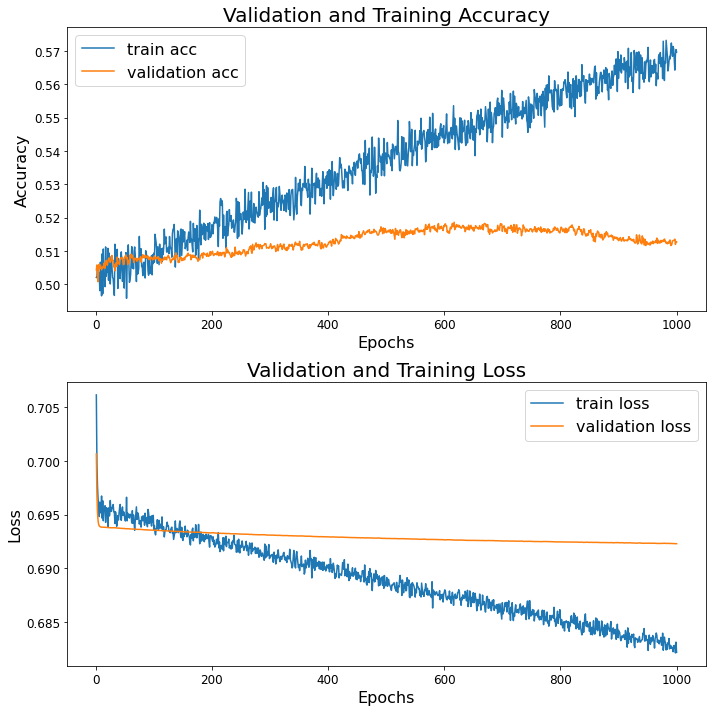

In [ ]:
device = torch.device('cuda')
train_file = 'combined_messy_train_set_50.json'
test_file  = 'combined_messy_test_set_50.json'
messy_base = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_messy_meta_set_100.json  and  combined_messy_meta_test_set_100.json For this Experiment


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in long_scalars



Average Test Loss: 0.436 | Average Test Accuracy: 0.833
Average Test Precision: nan | Average Test Recall:  0.000


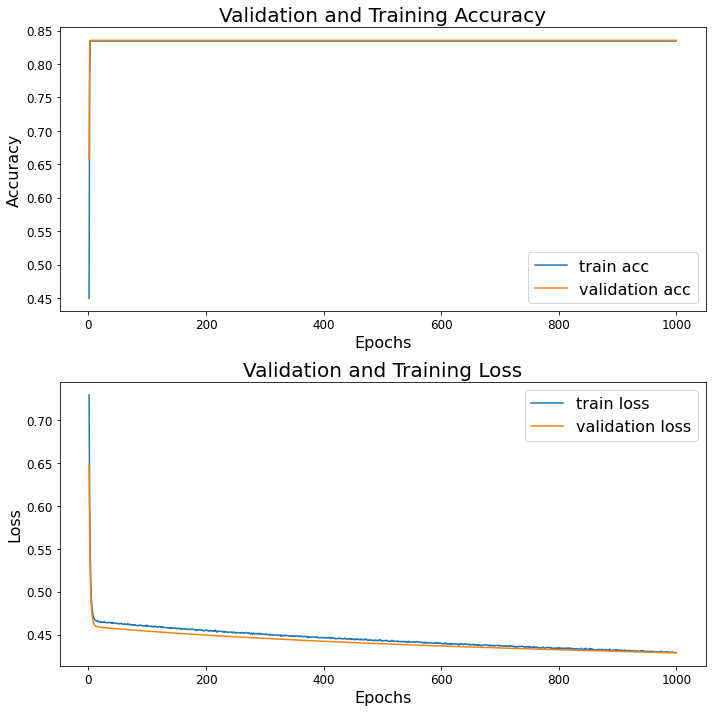

In [ ]:
device = torch.device('cuda')
train_file = 'combined_messy_meta_set_100.json'
test_file  = 'combined_messy_meta_test_set_100.json'
messy_meta = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_messy_meta_set_50.json  and  combined_messy_meta_test_set_50.json For this Experiment


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in long_scalars



Average Test Loss: 0.441 | Average Test Accuracy: 0.836
Average Test Precision: nan | Average Test Recall:  0.000


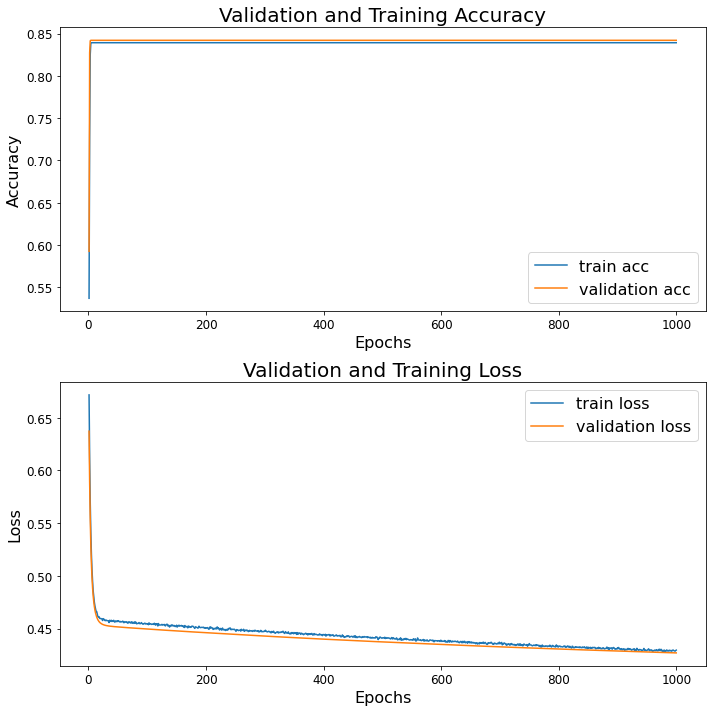

In [ ]:
device = torch.device('cuda')
train_file = 'combined_messy_meta_set_50.json'
test_file  = 'combined_messy_meta_test_set_50.json'
messy_meta = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)

## Clean data

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_train_set_100.json  and  combined_test_set_100.json For this Experiment



Average Test Loss: 0.694 | Average Test Accuracy: 0.510
Average Test Precision: 0.498 | Average Test Recall:  0.375


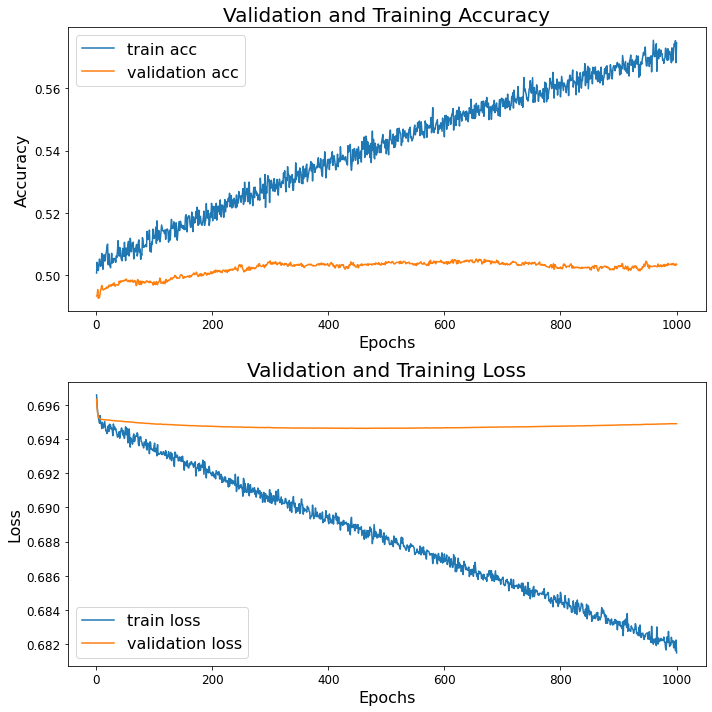

In [ ]:
device = torch.device('cuda')
train_file = 'combined_train_set_100.json'
test_file  = 'combined_test_set_100.json'
clean_base = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_train_set_50.json  and  combined_test_set_50.json For this Experiment



Average Test Loss: 0.695 | Average Test Accuracy: 0.498
Average Test Precision: 0.488 | Average Test Recall:  0.468
{'label': '1000_0.1_combined_test_set_50.json_combined_train_set_50.json_experiment', 'precision': 0.4880362478458886, 'recall': 0.46773584905660376, 'accuracy': 0.4984470172676929, 'loss': 0.6946765468564144}


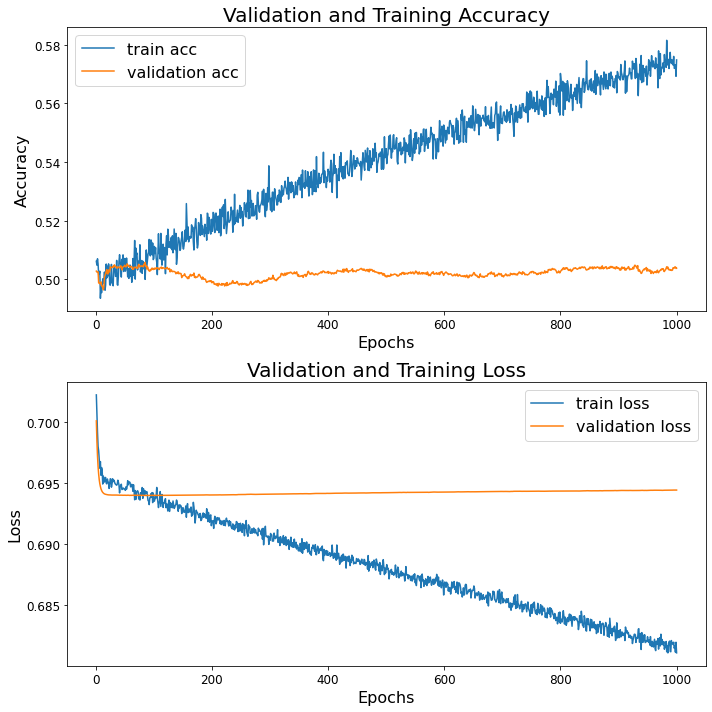

In [ ]:
device = torch.device('cuda')
train_file = 'combined_train_set_50.json'
test_file  = 'combined_test_set_50.json'
clean_base_50 = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)
print(clean_base_50)

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_meta_set_100.json  and  combined_meta_test_set_100.json For this Experiment



Average Test Loss: 0.634 | Average Test Accuracy: 0.648
Average Test Precision: 0.616 | Average Test Recall:  0.587


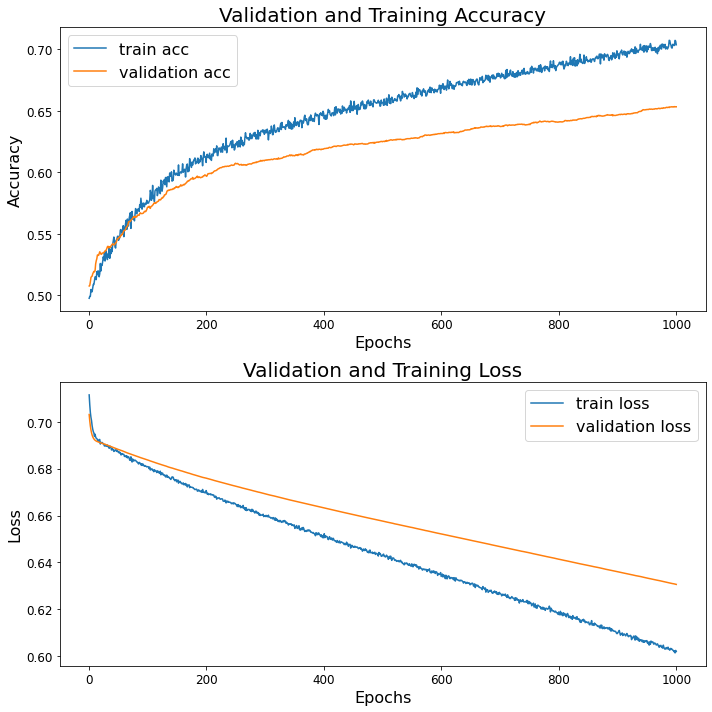

In [ ]:
device = torch.device('cuda')
train_file = 'combined_meta_set_100.json'
test_file  = 'combined_meta_test_set_100.json'
clean_meta = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)

Running Experiment with 1000 epochs and 0.1 dropout--------------------
Using  combined_meta_set_50.json  and  combined_meta_test_set_50.json For this Experiment



Average Test Loss: 0.661 | Average Test Accuracy: 0.603
Average Test Precision: 0.687 | Average Test Recall:  0.301
{'label': '1000_0.1_combined_meta_test_set_50.json_combined_meta_set_50.json_experiment', 'precision': 0.6871094700453714, 'recall': 0.3006628787878788, 'accuracy': 0.6025462970137596, 'loss': 0.6608841261929936}


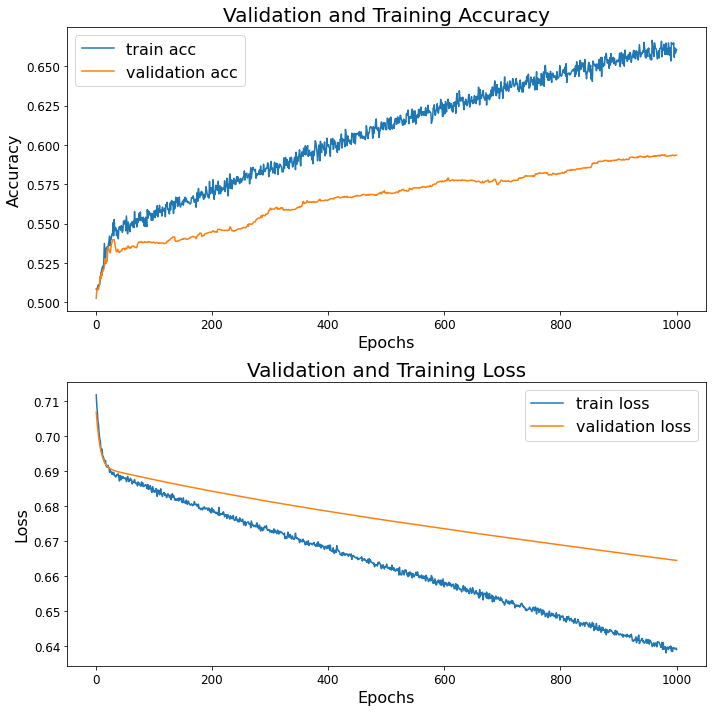

In [ ]:
device = torch.device('cuda')
train_file = 'combined_meta_set_50.json'
test_file  = 'combined_meta_test_set_50.json'
clean_meta_50 = run_experiment(train_file, test_file, device, num_epochs = 1000, drpout = 0.1)
print(clean_meta_50)

In [ ]:
print(messy_base)
print(messy_meta)
print(clean_base)
print(clean_meta)

{'label': '1000_0.1_combined_messy_test_set_100.json_combined_messy_train_set_100.json_experiment', 'precision': 0.5000982540997646, 'recall': 0.35236570615439344, 'accuracy': 0.5164852682705765, 'loss': 0.6924231227610137}
{'label': '1000_0.1_combined_messy_meta_test_set_100.json_combined_messy_meta_set_100.json_experiment', 'precision': nan, 'recall': 0.0, 'accuracy': 0.8329055055975914, 'loss': 0.43572136452421545}
{'label': '1000_0.1_combined_test_set_100.json_combined_train_set_100.json_experiment', 'precision': 0.4984135568385444, 'recall': 0.3754246885617214, 'accuracy': 0.5101482577183667, 'loss': 0.6935089277870514}
{'label': '1000_0.1_combined_meta_test_set_100.json_combined_meta_set_100.json_experiment', 'precision': 0.6163426510832204, 'recall': 0.5868706811451135, 'accuracy': 0.6477962025574275, 'loss': 0.63418074292796}


# Reweighted Model
## Config

## Training

In [ ]:
def run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 100, drpout = 0.25, num_repeats = 4, batch_size = 64):
  params = {
  'max_vocab': 25000,
  'epochs':num_epochs,
  'batch_size':batch_size,
  'dropout':drpout,
  'lr':.00001
  }
  accuracy_stats = {
    'train': np.zeros(params['epochs']),
    'meta': np.zeros(params['epochs']),
    "val": np.zeros(params['epochs'])
  }
  loss_stats = {
    'train': np.zeros(params['epochs']),
    "meta": np.zeros(params['epochs']),
    "val": np.zeros(params['epochs'])
  }
  testing_stats = {
    "label":f"l2rw_{test_file}_{train_file}_{meta_file}__experiment",
    'accuracy': 0,
    'loss': 0,
    'precision': 0,
    'recall': 0
  }
  for i in tqdm(range(num_repeats)):
    SEED = 1234
    TEXT= data.Field()
    LABEL = data.LabelField(dtype=torch.float)
    fields = {'text': ('t', TEXT), 'label': ('l', LABEL)}
    train_set, test_data = data.TabularDataset.splits(
      path='model_data',
      train = train_file,
      test = test_file,
      format = 'json',
      fields = fields
    )
    meta_name =  "model_data/" + meta_file
    meta_values = data.TabularDataset(path=meta_name, fields = fields, format='json')
    train_data, valid_data = train_set.split(random_state = random.seed(SEED))
    TEXT.build_vocab(train_data, max_size = params['max_vocab'], vectors =  'glove.twitter.27B.100d');
    LABEL.build_vocab(train_data);
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = params['batch_size'],
        sort_within_batch = True,
        sort_key = lambda x: len(x.t),
        device = device
    )
    meta_iterator = data.BucketIterator(meta_values, 
                                        batch_size=params['batch_size'],
                                        sort_within_batch=True,
                                        sort_key = lambda x: len(x.t),
                                        device = device)
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 100
    N_FILTERS = 110
    FILTER_SIZES = [1,2,3,4,5]
    OUTPUT_DIM = 1
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, params['dropout'], PAD_IDX)
    pretrained_embeddings = TEXT.vocab.vectors
    ################################################
    if TEXT.vocab.vectors != None:
      model.embedding.weight.data.copy_(pretrained_embeddings);
    ####################################################
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    criterion = criterion.to(device)

    best_valid_loss = float('inf')
    ####################################################TRAINING
    for epoch in tqdm(range(params['epochs'])):
      model.train()
      training_loss = 0
      training_accuracy = 0
      meta_loss = 0
      meta_accuracy = 0
      num_iter = 0
      for _,(inputs, labels) in enumerate(train_iterator):
        optimizer.zero_grad();
        print(inputs)
        with higher.innerloop_ctx(model, optimizer) as (meta_model, meta_opt):
          meta_train_outputs = meta_model(inputs)
          criterion.reduction = 'none'
          meta_train_loss = criterion(meta_train_outputs.squeeze(), labels.type_as(meta_train_outputs))
          eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=device)
          meta_train_loss = torch.sum(eps * meta_train_loss)
          meta_opt.step(meta_train_loss)
          meta_inputs, meta_labels =  next(iter(meta_iterator))
          meta_val_outputs = meta_model(meta_inputs)
          criterion.reduction = 'mean'
          meta_val_loss = criterion(meta_val_outputs.squeeze(), meta_labels.type_as(meta_val_outputs))
          ### Recording meta statistics
          meta_loss += meta_val_loss.item()
          meta_accuracy += binary_accuracy(meta_val_outputs.squeeze(), meta_labels.type_as(meta_val_outputs))
          ###
          eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()
        w_tilde = torch.clamp(-eps_grads, min=0)
        l1_norm = torch.sum(w_tilde)
        if l1_norm != 0:
            w = w_tilde / l1_norm
        else:
            w = w_tilde
        # 4. Train model on weighted batch
        outputs = model(inputs)
        criterion.reduction = 'none'
        minibatch_loss = criterion(outputs.squeeze(), labels.type_as(outputs))
        ## Recording Test Statistics
        training_loss += torch.mean(minibatch_loss).item()
        training_accuracy += binary_accuracy(outputs.squeeze(), labels.type_as(outputs))
        ###
        minibatch_loss = torch.sum(w * minibatch_loss)
        minibatch_loss.backward()
        optimizer.step()
        num_iter += 1
      ## Taking average per iteration
      loss_stats['train'][epoch] += training_loss / num_iter
      loss_stats['meta'][epoch] += meta_loss / num_iter
      accuracy_stats['train'][epoch] += training_accuracy /num_iter
      accuracy_stats['meta'][epoch] += meta_accuracy /num_iter
      ## Finding Validation Accuracy
      vaccuracy, vloss, vprecision, vrecall = evaluate_test(model, valid_iterator, criterion)
      loss_stats['val'][epoch] += vloss
      accuracy_stats['val'][epoch] += vaccuracy
      if vloss < best_valid_loss:
        best_valid_loss = vloss
        torch.save(model.state_dict(), 'l2rw-model-final.pt')
    taccuracy, tloss, tprecision, trecall = evaluate_test(model, test_iterator, criterion)
    testing_stats['accuracy'] += taccuracy
    testing_stats['loss'] += tloss
    testing_stats['precision'] += tprecision
    testing_stats['recall'] += trecall
    ################################## END TRAINING
    ## Cleaning everything ####
    gc.collect()
    torch.cuda.empty_cache()
  testing_stats['accuracy'] /= num_repeats
  testing_stats['loss'] /= num_repeats
  testing_stats['precision'] /= num_repeats
  testing_stats['recall'] /= num_repeats
  loss_stats['train'] /= num_repeats
  loss_stats['meta'] /= num_repeats
  loss_stats['val'] /= num_repeats
  accuracy_stats['train'] /= num_repeats
  accuracy_stats['meta'] /= num_repeats
  accuracy_stats['val'] /= num_repeats
  fig, axs = plt.subplots(2, figsize=(10,10))
  print(testing_stats)
  axs[0].set_title('Validation,Training, and Meta Accuracy', fontsize=20)
  axs[0].plot(range(1,params['epochs'] + 1), accuracy_stats['train'], label='train acc');
  axs[0].plot(range(1,params['epochs'] + 1), accuracy_stats['meta'], label='meta acc');
  axs[0].plot(range(1,params['epochs'] + 1), accuracy_stats['val'], label='validation acc');
  axs[0].set_xlabel('Epochs', fontsize=16)
  axs[0].set_ylabel('Accuracy', fontsize=16)
  axs[0].legend(prop={"size":16})
  axs[1].set_title('Validation, Training, and Meta Loss', fontsize=20)
  axs[1].plot(range(1, params['epochs'] + 1), loss_stats['train'], label='train loss')
  axs[1].plot(range(1, params['epochs'] + 1), loss_stats['meta'], label='meta loss')
  axs[1].plot(range(1, params['epochs'] + 1), loss_stats['val'], label='validation loss')
  axs[1].set_xlabel('Epochs', fontsize=16)
  axs[1].set_ylabel('Loss', fontsize=16)
  axs[1].legend(prop={"size":16})
  plt.tight_layout()
  plot_name = "experimental_figures/"+testing_stats['label'] + ".jpg"
  fig.savefig(plot_name)
  return testing_stats

In [ ]:
train_file = 'combined_train_set_100.json'
test_file = 'combined_test_set_100.json'
meta_file = 'combined_meta_set_100.json'
device = torch.device('cuda')
testing_stats = run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 70, drpout = 0.1, num_repeats=1, batch_size=32)
print(testing_stats)



{'label': 'l2rw_combined_messy_test_set_100.json_combined_messy_train_set_100.json_experiment', 'accuracy': 0.8738477459320655, 'loss': 0.48417299625637766, 'precision': 0.48390428645205713, 'recall': 1.0}
{'label': 'l2rw_combined_messy_test_set_100.json_combined_messy_train_set_100.json_experiment', 'accuracy': 0.8738477459320655, 'loss': 0.48417299625637766, 'precision': 0.48390428645205713, 'recall': 1.0}


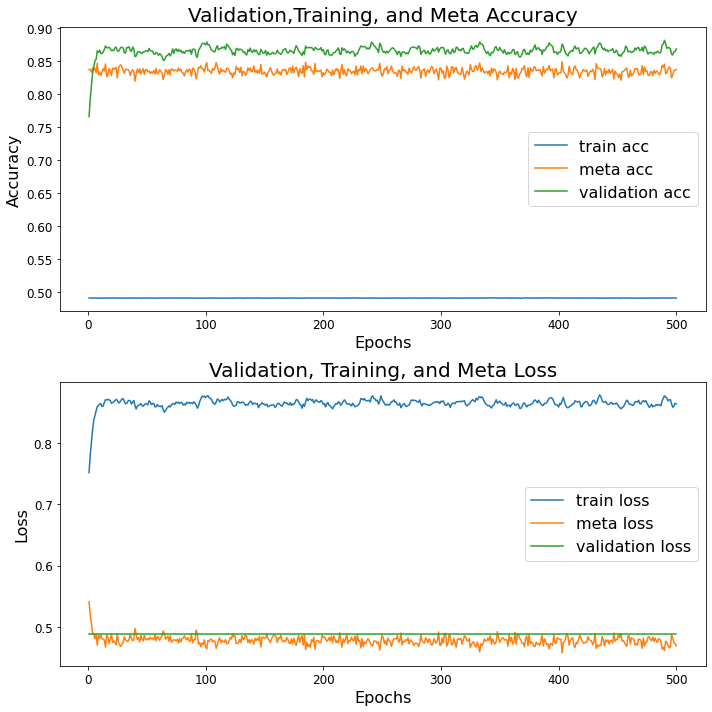

In [ ]:
train_file = 'combined_messy_train_set_100.json'
test_file = 'combined_messy_test_set_100.json'
meta_file = 'combined_messy_meta_set_100.json'
device = torch.device('cuda')
testing_stats = run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 500, drpout = 0.1, batch_size = 32, num_repeats=1)
print(testing_stats)



{'label': 'l2rw_combined_test_set_50.json_combined_train_set_50.json_experiment', 'accuracy': 0.7004956204530806, 'loss': 0.4896871541128602, 'precision': 0.48991749836980847, 'recall': 0.9583018867924528}
{'label': 'l2rw_combined_test_set_50.json_combined_train_set_50.json_experiment', 'accuracy': 0.7004956204530806, 'loss': 0.4896871541128602, 'precision': 0.48991749836980847, 'recall': 0.9583018867924528}


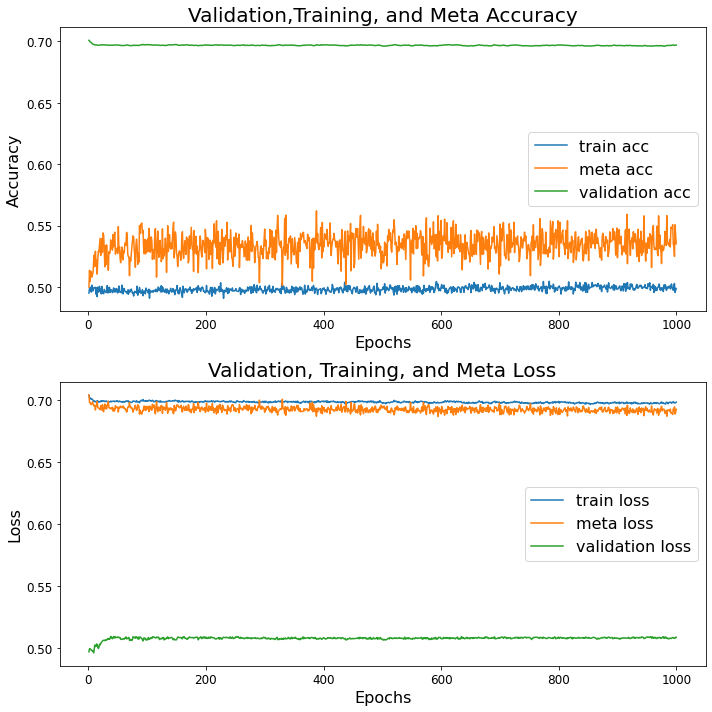

In [ ]:
train_file = 'combined_train_set_50.json'
test_file = 'combined_test_set_50.json'
meta_file = 'combined_meta_set_50.json'
device = torch.device('cuda')
import gc
gc.collect()
torch.cuda.empty_cache()
testing_stats = run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 1000, drpout = 0.1)
print(testing_stats)

In [ ]:
train_file = 'combined_train_set_50.json'
test_file = 'combined_test_set_50.json'
meta_file = 'combined_meta_set_50.json'
device = torch.device('cuda')
import gc
gc.collect()
torch.cuda.empty_cache()
testing_stats = run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 10, drpout = 0.1)
print(testing_stats)



{'label': 'l2rw_combined_messy_test_set_50.json_combined_messy_train_set_50.json_experiment', 'accuracy': 0.8730380710052408, 'loss': 0.48254371466843976, 'precision': 0.48260420254908715, 'recall': 1.0}
{'label': 'l2rw_combined_messy_test_set_50.json_combined_messy_train_set_50.json_experiment', 'accuracy': 0.8730380710052408, 'loss': 0.48254371466843976, 'precision': 0.48260420254908715, 'recall': 1.0}


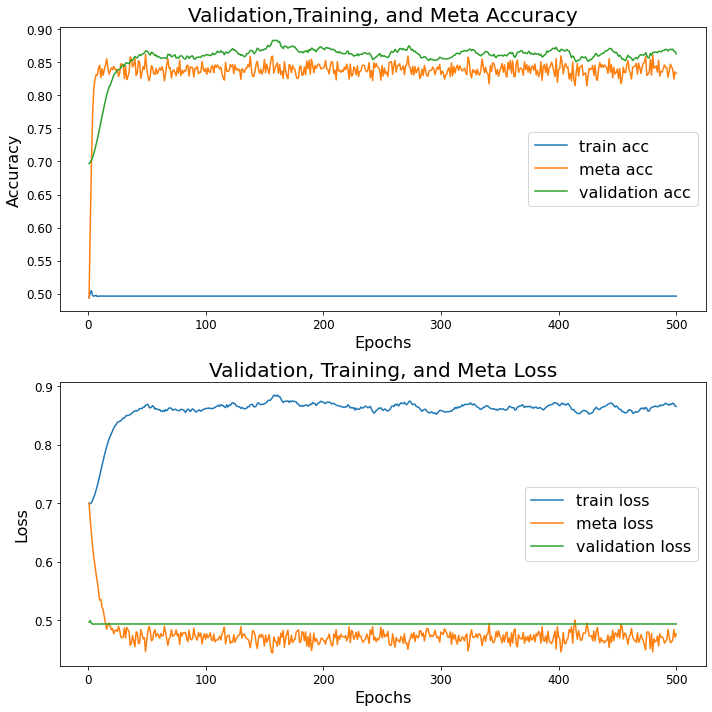

In [ ]:
train_file = 'combined_messy_train_set_50.json'
test_file = 'combined_messy_test_set_50.json'
meta_file = 'combined_messy_meta_set_50.json'
device = torch.device('cuda')
import gc
gc.collect()
torch.cuda.empty_cache()
testing_stats = run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 500, drpout = 0.1)
print(testing_stats)



{'label': 'l2rw_combined_test_set_100.json_combined_train_set_100.json_modified_meta_set_100.json__experiment', 'accuracy': 0.8564418098505806, 'loss': 0.4886748720617855, 'precision': 0.4885651051272593, 'recall': 1.0}
{'label': 'l2rw_combined_test_set_100.json_combined_train_set_100.json_modified_meta_set_100.json__experiment', 'accuracy': 0.8564418098505806, 'loss': 0.4886748720617855, 'precision': 0.4885651051272593, 'recall': 1.0}


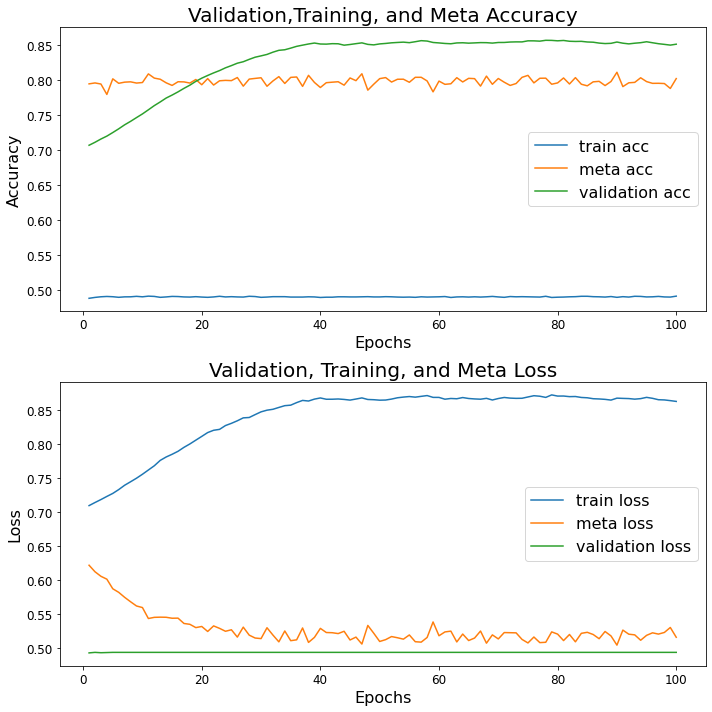

In [ ]:
train_file = 'combined_train_set_100.json'
test_file = 'combined_test_set_100.json'
meta_file = 'modified_meta_set_100.json'
device = torch.device('cuda')
import gc
gc.collect()
torch.cuda.empty_cache()
testing_stats = run_l2rw_experiment(train_file, test_file, meta_file, device, num_epochs = 100, drpout = 0.1, batch_size = 64, num_repeats=1)
print(testing_stats)

In [ ]:
#### Training
params = {
  'max_vocab': 25000,
  'epochs':500,
  'batch_size':64,
  'dropout':0.2,
  'lr':.00001
}
loss_stats = {
  'train': np.zeros(params['epochs']),
  'meta': np.zeros(params['epochs'])
}
testing_stats = {
  'loss': np.zeros(params['epochs']),
  'acc': np.zeros(params['epochs']),
  'prec': np.zeros(params['epochs']),
  'rec': np.zeros(params['epochs'])
}
device = torch.device('cuda')

SEED = 1234
TEXT= data.Field()
LABEL = data.LabelField(dtype=torch.float)
fields = {'text': ('t', TEXT), 'label': ('l', LABEL)}

train_data, test_data = data.TabularDataset.splits(
    path='model_data',
    train = 'combined_train_set_100.json',
    test = 'combined_test_set_100.json',
    format = 'json',
    fields = fields
)
meta_values = data.TabularDataset(path='model_data/combined_meta_set_100.json', fields = fields, format='json')
#train_data, valid_data = train_set.split(random_state = random.seed(SEED))
TEXT.build_vocab(train_data, max_size = params['max_vocab'], vectors =  'glove.twitter.27B.100d');
LABEL.build_vocab(train_data);
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, meta_values, test_data), 
    batch_size = params['batch_size'],
    sort_within_batch = True,
    sort_key = lambda x: len(x.t),
    device = device)
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 110
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
print(len(test_iterator))
model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, params['dropout'], PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors
################################################
if TEXT.vocab.vectors != None:
  model.embedding.weight.data.copy_(pretrained_embeddings);
####################################################
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.SGD(model.parameters(), lr=params['lr'])
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

best_testing_acc = 0

85


In [ ]:

for epoch in tqdm(range(params['epochs'])):
  model.train()
  train_loss, train_acc = 0,0
  num_iter = 0
  for _,(inputs, labels) in enumerate(train_iterator):
    optimizer.zero_grad();
    with higher.innerloop_ctx(model, optimizer) as (meta_model, meta_opt):
      meta_train_outputs = meta_model(inputs)
      criterion.reduction = 'none'
      meta_train_loss = criterion(meta_train_outputs.squeeze(), labels.type_as(meta_train_outputs))
      #loss_stats['meta'][epoch] += torch.mean(meta_train_loss).item()
      eps = torch.zeros(meta_train_loss.size(), requires_grad=True, device=device)
      meta_train_loss = torch.sum(eps * meta_train_loss)
      meta_opt.step(meta_train_loss)
      meta_inputs, meta_labels =  next(iter(valid_iterator))
      meta_val_outputs = meta_model(meta_inputs)
      criterion.reduction = 'mean'
      meta_val_loss = criterion(meta_val_outputs.squeeze(), meta_labels.type_as(meta_val_outputs))
      loss_stats['meta'][epoch] += meta_val_loss.item()
      eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()
    w_tilde = torch.clamp(-eps_grads, min=0)
    l1_norm = torch.sum(w_tilde)
    if l1_norm != 0:
        w = w_tilde / l1_norm
    else:
        w = w_tilde
    # 4. Train model on weighted batch
    outputs = model(inputs)
    criterion.reduction = 'none'
    minibatch_loss = criterion(outputs.squeeze(), labels.type_as(outputs))
    train_loss += torch.mean(minibatch_loss).item()
    minibatch_loss = torch.sum(w * minibatch_loss)
    loss_stats['train'][epoch] += minibatch_loss.item()
    minibatch_loss.backward()
    optimizer.step()
    num_iter += 1
  loss_stats['train'][epoch] /= len(train_iterator)
  loss_stats['meta'][epoch] /= len(train_iterator)
taccuracy, tloss, tprecision, trecall = evaluate_test(model, test_iterator, criterion)
print(f"accuracy: {taccuracy}, loss {tloss}, tprecision {tprecision}, trecall {trecall}")


accuracy: 0.7593093339134666, loss 0.4877557544147267, tprecision 0.4875698593177876, trecall 0.9550773876934693


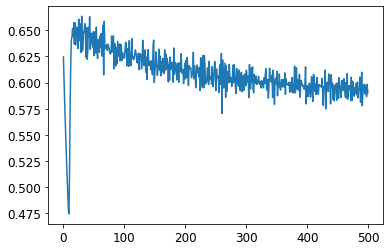

In [ ]:
plt.plot(range(500), loss_stats['train'])